In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


## Unperturbed image

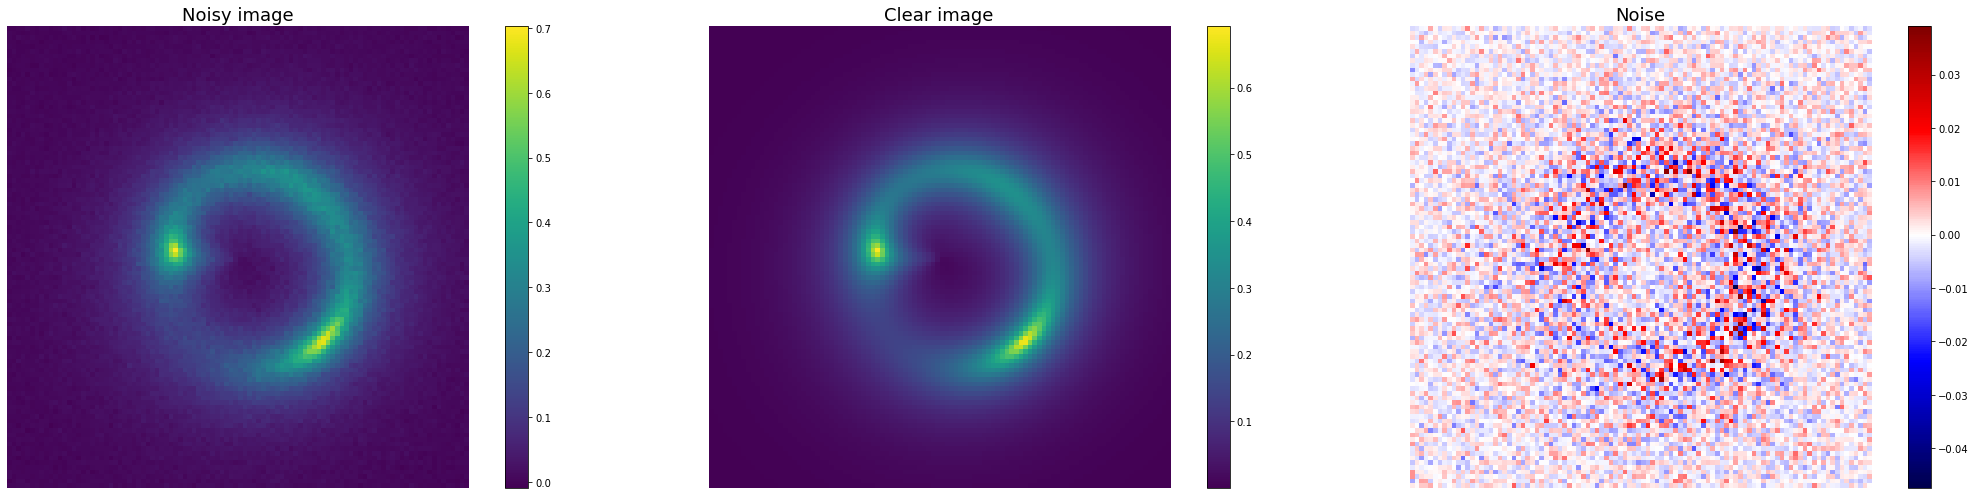

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# Spectrum simulation

In [4]:
logA_borders=[-9.7,-6.87]
Beta_borders=[0,4.7]

In [5]:
def show_resid(args,image):
    normalised_masked_residuals=((image-simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args),Noise_flag=False))*Observation_conditions.annulus_mask)/np.sqrt(Observation_conditions.noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    im=plt.imshow(normalised_masked_residuals,extent=Observation_conditions.pixel_grid.extent,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=plt.colorbar(im,ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    print('Loss={:.2f}'.format(Inference.image_loss(args,image)))
    plt.show()

In [6]:
simulate_perturbed_image=Observation_conditions.perturbed_image_getter
Lens_images=np.zeros((2,2,100,100))

get_GRF=Inference.GRF_getters(from_index=True)

for i,logA in tqdm(enumerate(logA_borders)):
    for j,Beta in enumerate(Beta_borders):
        GRF_potential=get_GRF([logA,Beta],0)
        Lens_images[i,j]=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data)

2it [00:00,  3.35it/s]


2it [00:00, 48.87it/s]


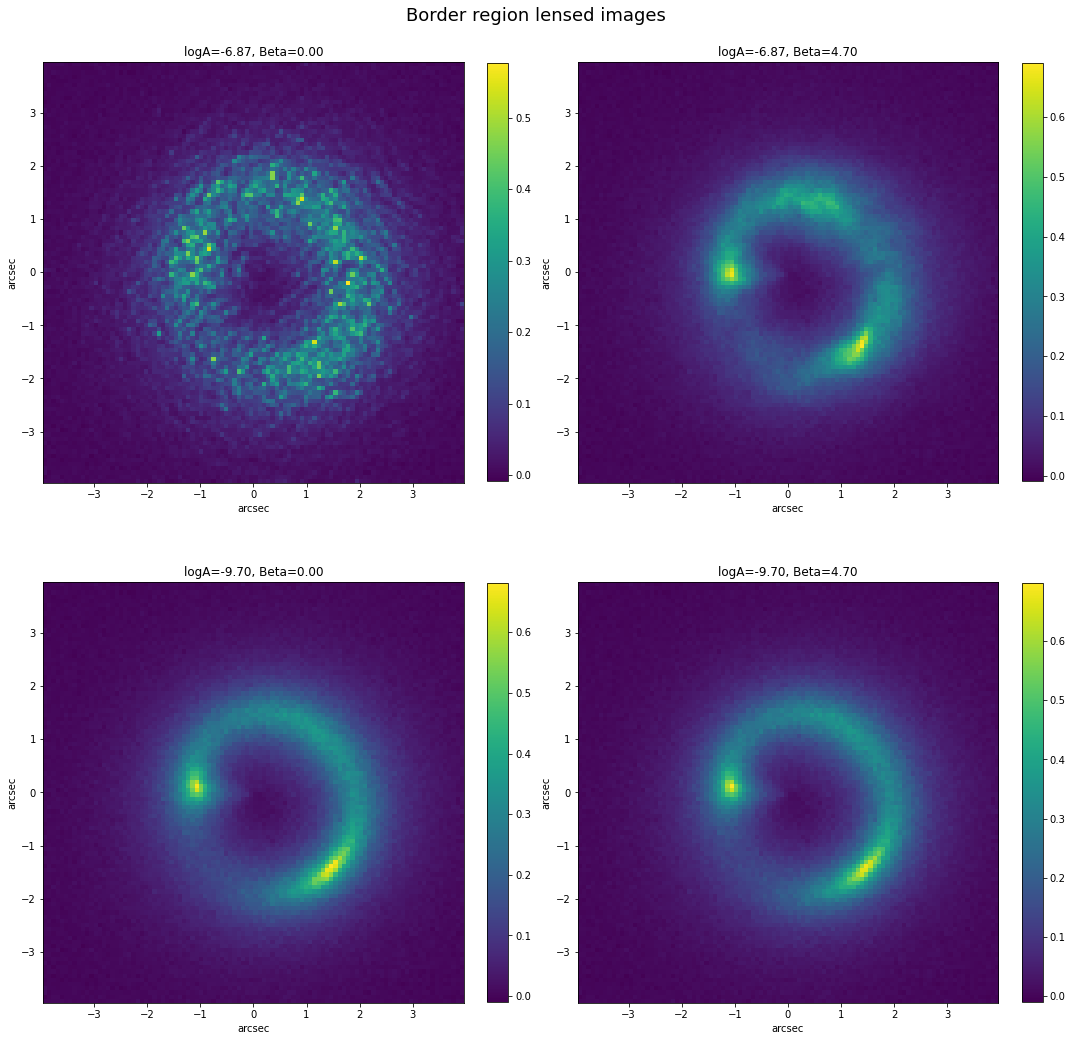

In [7]:
fig,ax=plt.subplots(2,2,figsize=(15,15))

for i,logA in tqdm(enumerate(logA_borders)):
    for j,Beta in enumerate(Beta_borders):
        im=ax[~i,j].imshow(Lens_images[i,j],extent=Observation_conditions.pixel_grid.extent)
        plt.colorbar(im,ax=ax[~i,j],fraction=0.045)
        ax[~i,j].set_title('logA={:.2f}'.format(logA)+', Beta={:.2f}'.format(Beta))
        ax[~i,j].set_xlabel('arcsec')
        ax[~i,j].set_ylabel('arcsec')

fig.suptitle('Border region lensed images',fontsize=FS)
fig.tight_layout()
plt.show()

In [15]:
for i,logA in tqdm(enumerate(logA_borders)):
    for j,Beta in enumerate(Beta_borders):
        GRF_potential=get_GRF([logA,Beta],50)
        Lens_images[i,j]=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data)

2it [00:00, 56.11it/s]


Loss=12.81


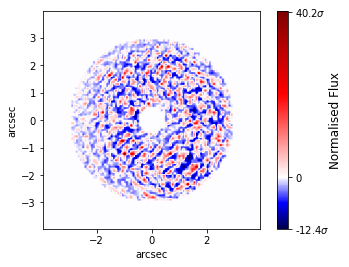

Loss=12.84


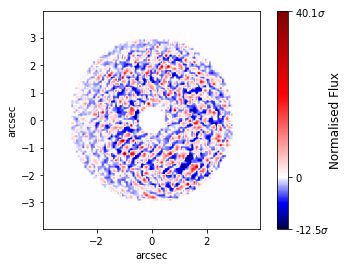

In [16]:
image=Lens_images[-1,0]
args_sc_fit=Inference.scipy_fit_image(image,initial_values=Observation_conditions.parameters.kwargs2args(Observation_conditions.kwargs_data))
show_resid(args_sc_fit,image)
Inference.SL_max_iter=1000
Inference.SL_learning_rate=5e-4
args_dif_fit=Inference.differentiable_fit_image(image)
show_resid(args_dif_fit,image)

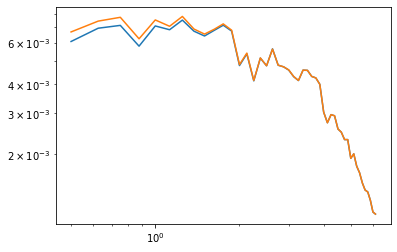

In [69]:
plt.loglog(Observation_conditions.frequencies,Inference.compute_radial_spectrum(image-simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_sc_fit),Noise_flag=False)))
plt.loglog(Observation_conditions.frequencies,Inference.compute_radial_spectrum(image-simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_dif_fit),Noise_flag=False)))

Loss=13.35


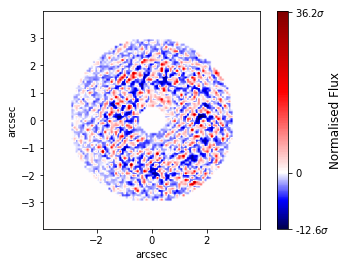

In [41]:
Inference.SL_max_iter=5000
Inference.SL_learning_rate=5e-5
args_dif_fit=Inference.differentiable_fit_image(image,args_guess=Observation_conditions.parameters.kwargs2args(Observation_conditions.kwargs_data))
show_resid(args_dif_fit,image)

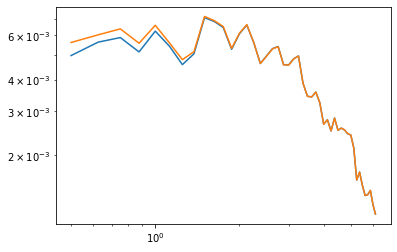

In [49]:
plt.loglog(Observation_conditions.frequencies,Inference.compute_radial_spectrum(image-simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_sc_fit),Noise_flag=False)))
plt.loglog(Observation_conditions.frequencies,Inference.compute_radial_spectrum(image-simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_dif_fit),Noise_flag=False)))

In [17]:
compute_spectrum_pure=lambda logA,Beta,Fourier_phase: Inference.Residual_spectrum_for_GRF(jnp.array([logA,Beta]),Fourier_phase)

In [19]:
compute_spectrum_seeds= lambda logA,Beta: jax_map(lambda Fourier_phase: compute_spectrum_pure(logA,Beta,Fourier_phase),Inference.Fourier_phase_tensor[:10])

In [20]:
compute_spectrum_seeds(-7.,2.)

KeyboardInterrupt: 

In [12]:
Observation_conditions.parameters.kwargs2args(Observation_conditions.kwargs_data)

DeviceArray([ 1.6 ,  0.15, -0.04,  0.  ,  0.  , -0.01,  0.03, 10.  ,
              1.2 ,  1.5 ,  0.07, -0.1 ,  0.4 ,  0.15], dtype=float64)

In [21]:
simulate_unperturbed_image??